### Imports

In [84]:
from tkinter import *
from tkinter.messagebox import askyesno
from queue import Queue
from tqdm.notebook import tqdm
from termcolor import colored
from matplotlib import pyplot as plt

from tensorflow.keras import Model, models
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2D, concatenate, LeakyReLU
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.activations import sigmoid

import time
import numpy as np
import tensorflow as tf
import random
import copy

EPS = np.finfo(float).eps

In [2]:
class PriorityQueue:
    def __init__(self):
        self.queue = {}
        self.lowest_prio = None
        
    def empty(self):
        return len(self.queue) == 0
        
    def put(self, item):
        self.queue[item[1]] = item
        if not self.lowest_prio or item < self.lowest_prio:
            self.lowest_prio = item
        
    def get(self):
        if self.lowest_prio is not None:
            item = self.lowest_prio
            self.lowest_prio = None
        else:
            item = min(self.queue.values())
            
        del self.queue[item[1]]
        return item[1]
    
    def remove(self, item):
        if self.lowest_prio is not None and self.lowest_prio[1] == item:
            self.lowest_prio = None
        del self.queue[item]
    
    def __contains__(self, item):
        return item in self.queue.keys()

# Project - Hex game

---

101804 - Advanced Machine Learning

Laurea Magistrale - Computer science

Artificial Intelligence Track

University of Genova

---

Instructors:

- Noceti Nicoletta
- Rosasco Lorenzo
- Barla Annalisa
- Verri Alessandro

---

Student: Arnaud Ruymaekers, S5298338

---

Project pitch:

I was thinking to pick the "infinite state and infinite action" Reinforcement learning project. For this I was interested in implementing an agent for the game Hex (https://en.wikipedia.org/wiki/Hex_(board_game)) so as to push further the concepts seen for the tick tac toe lab.

## 0) Introduction

In this project, I will explore build an Agent able to play the board game Hex.

Hex is 2 player where the goal is to link it's assigned two sides of the field. On interesting challenge about this game is that, due to the hexagonal architecture of the grid, there will always be a winner and a looser, there is no ties. It is usually played on a 11 by 11 or 13 by 13 board, which is a state space larger than the one of chess.

<img src="hex.png">

I will explore the building of the agents we built in class to this board-game. I will first build a trivial random play agent that will be used to play against other agents. Following this I will build a Minimax Agent with a limited search depth. Then, getting into reinforcement learning, I will build a TQ-learning agent. And finally I will a deep-Q learning agent.

## 1) Base Classes setup

In [3]:
TILE_COLORS = {
    -2: 'dark grey',
    -1: 'grey',
     1: 'red',
     2: 'blue'
}

### 1.1) Base player classes

In [4]:
# Player variables
PLAYER1 = 1
PLAYER2 = 2

OTHER_PLAYER = {
    PLAYER1: PLAYER2,
    PLAYER2: PLAYER1
}

In [5]:
# Abstraction of the player
class Player:
    def __init__(self, side):
        self.side = side
        self.other_side = OTHER_PLAYER[self.side]
        
    # Function to run for a player at each game start to allow the player to potentially set variables or run actions
    def start_game(self):
        pass
        
    # Given a move, it returns the result of the move and if the game is finished 
    # i.e. a tuple (GameResult,bool)
    def move(self, grid):
        pass
    
    # Function to run potential finalization actions after the game is wrapped up
    def finalize(self, winner):
        pass

In [6]:
class ManualPlayer(Player):
    pass

In [7]:
PLAYER_CLASSES = {
    'Manual': ManualPlayer
}

### 1.2) Game classes

#### 1.2.1) Variables

In [8]:
# Tile status
HOVERED = -2
EMPTY = -1

# Game status
STOPPED = 0
STARTED = 1
FINISHED = 2

GAME_SPEEDS = {
    'Slow': 2000,
    'Normal': 1000,
    'Fast': 100,
    'Instant': 10
}

HEX_DIRECTIONS = [( 1,0), ( 1,-1), (0,-1),
                  (-1,0), (-1, 1), (0, 1)]

#### 1.2.2) HexTile

In [118]:
class HexTile:
    def __init__(self, x:int, y:int, grid:'HexGrid', status:int=EMPTY) -> None:
        self.x: int = x
        self.y: int = y
        self.id: int = int((y*grid.size)+x)
        self.grid: 'HexGrid' = grid
        self._status: int = status
        self.neighbours: list['HexTile'] = []
        self.player_neighbours: dict[int, list['HexTile']] = {EMPTY: [], PLAYER1: [], PLAYER2: []}
        
        # Variables for shortest path finding for each player
        self.g_value: dict[int] = { # Shortest path from edge x(or y)=0
            PLAYER1: y+1,
            PLAYER2: x+1
        }
        self.rhs_value: dict[int] = { # Lookahead value based on on predecessor's tile
            PLAYER1: y+1,
            PLAYER2: x+1
        }
        self.comes_from = {
            PLAYER1: None,
            PLAYER2: None
        }
    
    
    @property
    def status(self) -> int:
        return self._status
    
    
    @status.setter
    def status(self, new_status:int) -> None:
        assert self.status == EMPTY
        
        # Update to the grids sets
        self.grid.status_tiles[self._status].remove(self)
        self.grid.status_tiles[new_status].append(self)
        if new_status in [PLAYER1, PLAYER2] and self in self.grid.end_edge_tiles[new_status]:
            self.grid.claimed_end_edge_tiles[new_status].append(self)
                        
        if new_status in [PLAYER1, PLAYER2]:
            self.grid.state_array[self.x, self.y] = new_status
            
        # Update state channels of the grid
        if new_status == PLAYER1:
            self.grid.state_channels[self.y, self.x, 0] = 1
            
            # Check bottom-left neighbour status
            if (self.y-1) >= 0 and (self.x+1) <= (self.grid.size-1) and self.grid.state_channels[self.y-1, self.x+1, 0] == 1:
                self.grid.state_channels[self.y, self.x, 2] = 1 # Bottom-left connection of current tile
                self.grid.state_channels[self.y-1, self.x+1, 3] = 1 # Top-right connection of bottom-left tile
                
            # Check top-right neighbour status
            if (self.x-1) >= 0 and (self.y+1) <= (self.grid.size-1) and self.grid.state_channels[self.y+1, self.x-1, 0] == 1:
                self.grid.state_channels[self.y, self.x, 3] = 1 # Top-right connection of current tile
                self.grid.state_channels[self.y+1, self.x-1, 2] = 1 # Bottom-left connection of current tile
            
        elif new_status == PLAYER2:
            self.grid.state_channels[self.y, self.x, 1] = 1
            
            # Check bottom-left neighbour status
            if (self.y-1) >= 0 and (self.x+1) <= (self.grid.size-1) and self.grid.state_channels[self.y-1, self.x+1, 1] == 1:
                self.grid.state_channels[self.y, self.x, 4] = 1 # Bottom-left connection of current tile
                self.grid.state_channels[self.y-1, self.x+1, 5] = 1 # Top-right connection of bottom-left tile
                
            # Check top-right neighbour status
            if (self.x-1) >= 0 and (self.y+1) <= (self.grid.size-1) and self.grid.state_channels[self.y+1, self.x-1, 1] == 1:
                self.grid.state_channels[self.y, self.x, 5] = 1 # Top-right connection of current tile
                self.grid.state_channels[self.y+1, self.x-1, 4] = 1 # Bottom-left connection of current tile

        # tile status update
        self._status = new_status
        
        if new_status in [PLAYER1, PLAYER2]:
            # update neighbour tiles sets
            for neighbour in self.neighbours:
                neighbour.player_neighbours[EMPTY].remove(self)
                neighbour.player_neighbours[new_status].append(self)
                
            for player in [PLAYER1, PLAYER2]:
                self.grid.update_node(player, self)
                self.grid.expand_nodes(player)
    
    
    def __lt__(self, other):
        return self.id < other.id
    

    def __repr__(self):
        return f'<HexTile at (x={self.x}, y={self.y})>'

#### 1.2.3) HexGrid

In [103]:
class HexGrid:
    def __init__(self, size):
        self.size = size
        self.turn_number = 0
        self.state_array = np.zeros((size, size))
        
        # Channels arrays
        self.state_channels = np.zeros((size, size, 6))
        
        # Tile generation
        self.tiles = []
        for y in range(size):
            for x in range(size):
                self.tiles.append(HexTile(x,y,self))
        
        # Linking each tile to its neighbours
        for tile in self.tiles:
            for d in HEX_DIRECTIONS:
                new_x = tile.x + d[0]
                new_y = tile.y + d[1]

                # Only take coordinates in the grid
                if (0 <= new_x < self.size) and (0 <= new_y < self.size):
                    neighbour = self.get_tile(new_x, new_y)
                    tile.neighbours.append(neighbour)
                    tile.player_neighbours[EMPTY].append(neighbour)
                    
        # Making status tile dictionary
        self.status_tiles = {
            HOVERED: [],
            EMPTY: [tile for tile in self.tiles],
            PLAYER1: [],
            PLAYER2: []
        }
        
        # Making player edge tiles dictionaries
        self.start_edge_tiles = {}
        self.end_edge_tiles = {}
        self.claimed_end_edge_tiles = {}
        
        # Shortest path queue
        self.exploration_queue = {}
        
        # Shortest recorded distances
        self.shortest_dist = {}
        
        # Populating dictionaries
        for player in [PLAYER1, PLAYER2]:
            self.start_edge_tiles[player] = [tile for tile in self.tiles if (tile.y == 0 and player == PLAYER1) or (tile.x == 0 and player == PLAYER2)]
            self.end_edge_tiles[player] = [tile for tile in self.tiles if (tile.y == (self.size - 1) and player == PLAYER1) or (tile.x == (self.size - 1) and player == PLAYER2)]
            self.claimed_end_edge_tiles[player] = []
            self.exploration_queue[player] = PriorityQueue()
            self.shortest_dist[player] = 11
            
            for tile in self.tiles:
                if tile not in self.start_edge_tiles[player]:
                    tile.comes_from[player] = self.get_tile(tile.x, tile.y-1) if player == PLAYER1 else self.get_tile(tile.x-1, tile.y)

    
    def get_tile(self, x:int, y:int) -> HexTile:
        return self.tiles[int((y*self.size)+x)]
    
    
    @property
    def empty_tiles(self) -> list[HexTile]:
        return self.status_tiles[EMPTY]
    
    
    def get_player_tiles(self, player:int) -> list[HexTile]:
        return self.status_tiles[player]
    
    
    def expand_nodes(self, player:int) -> None:
        explored_nodes = set()
        while not self.exploration_queue[player].empty():
            current_node = self.exploration_queue[player].get()
            explored_nodes.add(current_node)
            
            if current_node.rhs_value[player] < current_node.g_value[player]: # Overconsistant node
                current_node.g_value[player] = current_node.rhs_value[player]
                
            else: # Underconsistant node
                current_node.g_value[player] = np.inf
                self.update_node(player, current_node)
                
            for neighbour_node in current_node.neighbours:
                self.update_node(player, neighbour_node)
        
        # Update of the shortest distance variables
        self.shortest_dist[player] = min([tile.g_value[player] for tile in self.end_edge_tiles[player]])
        
        # Only update path for tiles that have been re-explored
        for node in explored_nodes:
            lowest_g = min([neighbour.g_value[player] for neighbour in node.neighbours])
            lowest_g_neighbours = [neighbour for neighbour in node.neighbours if neighbour.g_value[player] == lowest_g]
            node.comes_from[player] = random.choice(lowest_g_neighbours)
        
            
    def update_node(self, player:int, node:HexTile) -> None:
        node.rhs_value[player] = np.inf

        # Compute how much needs to be added to the distance based on the current node's status
        cost_addition = EPS
        if node.status == OTHER_PLAYER[player]:
            cost_addition = np.inf
        elif node.status == EMPTY:
            cost_addition = 1

        # If start edge node of current player set rhs as the cost_addition else check neighbours
        if node in self.start_edge_tiles[player]:
            node.rhs_value[player] = cost_addition
        else:
            for neighbour_node in node.neighbours:
                potential_rhs = neighbour_node.g_value[player] + cost_addition
                if potential_rhs < node.rhs_value[player]:
                    node.rhs_value[player] = potential_rhs

        # Remove to the exploration queue
        if node in self.exploration_queue[player]:
            self.exploration_queue[player].remove(node)

        # If rhs differs from g, add to queue with new cost
        if node.rhs_value[player] != node.g_value[player]:
            self.exploration_queue[player].put((min(node.g_value[player], node.rhs_value[player]), node))
            
            
    def get_shortest_paths(self, player):
        closest_end_edge_tiles = [tile for tile in self.end_edge_tiles[player] if tile.g_value[player] == self.shortest_dist[player]]
        paths = []
        for tile in closest_end_edge_tiles:
            path = []
            current_tile = tile
            path.append(tile)
            while current_tile not in self.start_edge_tiles[player]:
                current_tile = current_tile.comes_from[player]
                path.append(current_tile)
            path.reverse()
            paths.append(path)
        return paths
            
                    
    def check_win_player(self, player:int) -> bool:
        return self.shortest_dist[player] < 1
    
    
    def check_win(self) -> int:
        if self.check_win_player(PLAYER1):
            return PLAYER1
        elif self.check_win_player(PLAYER2):
            return PLAYER2
        else:
            return -1
    

    def hash_state(self, state_array):
        return hash(state_array.tobytes())
    
    
    def print_grid(self) -> None:
        for i in range(self.size):
            row_items = [colored(int(item),TILE_COLORS[item]) if item > 0 else str(int(item)) for item in self.state_array[:,i]]
            print('  '.join(['' for i in range(i+1)]) + '  '.join(row_items))
            
    
    def print_distances_player(self, player:int) -> None:
        for i in range(self.size):
            row_items = []
            for j in range(self.size):
                g = self.get_tile(j,i).g_value[player]
                row_items.append(f'{(0 if g < 1 else g):3.0f}')
            print('  '.join(['' for i in range(i+1)]) + '  '.join(row_items))

#### 1.2.4) HexGame

In [11]:
class HexGame:
    def __init__(self, player1:Player, player2:Player, grid_size:int=11):
        self.status = STOPPED
        
        self.active_player_nb = PLAYER1
        self.players = {
            PLAYER1:player1, 
            PLAYER2:player2
        }
        
        self.grid_size = grid_size
        self.grid = HexGrid(grid_size)
        
        
    @property
    def active_player(self) -> Player:
        return self.players[self.active_player_nb]
        
        
    def play_turn(self) -> int:
        if self.status == STARTED:
            if isinstance(self.active_player, ManualPlayer):
                pass
            else:
                self.active_player.move(self.grid)
                self.grid.turn_number += 1
                
                # Check for victory and finalize game
                win_status = -1
                if self.grid.check_win_player(self.active_player_nb):
                    win_status = self.active_player_nb
                    self.status = FINISHED
                    
                    # Send signal the game is over to both players
                    self.active_player.finalize(win_status)
                    self.players[self.active_player.other_side].finalize(win_status)

                self.switch_player()
                    
                return win_status
        
        
    def switch_player(self) -> None:
        # Swap player
        self.active_player_nb = OTHER_PLAYER[self.active_player_nb]

### 1.3) Helping functions

In [15]:
def play_game(p1, p2, grid_size=11, game_nb=0, suppress=False):
    game = HexGame(p1,p2, grid_size)
    game.status = STARTED
    p1.start_game()
    p2.start_game()
    
    turn_times = []
    for _ in tqdm(range(grid_size**2), position=1, leave=False, unit='turn', desc=f'Game {game_nb}', disable=suppress):
        t0 = time.time()
        result = game.play_turn()
        turn_times.append(time.time() - t0)
        
        # If there was a win, stop and return the winner
        if result > -1:
            break
    
    if result == -1:
        print(colored('/!\\ GAME UNFINISHED /!\\', 'red'))
    
    return result, game, turn_times

In [1]:
def play_n_games(p1, p2, n, grid_size=11, suppress_game_tqdm=True, print_stats=True, print_wins=False):
    p1_count = []
    p2_count = []
    game_list = []
    turn_times_list = []
    game_times = []

    with tqdm(range(n), position=0, unit='game') as pbar:
        for i in pbar:
            t0 = time.time()
            result, game, turn_times = play_game(p1, p2, grid_size, game_nb=i, suppress=suppress_game_tqdm)
            game_times.append(time.time() - t0)

            p1_count.append(1 if result == PLAYER1 else 0)
            p2_count.append(1 if result == PLAYER2 else 0)
            game_list.append(game)
            turn_times_list.append(turn_times)
            
            
            rolling_avg = np.average(p1_count) * 100
            
            pbar.set_postfix(p1_wins=rolling_avg, refresh=False)
        
    # Print out results
    print(f'After {n} games, we have:')
    print(f'  - Player 1 wins: {np.sum(p1_count)} ({np.average(p1_count) * 100:.2f}%)')
    print(f'  - Player 2 wins: {np.sum(p2_count)} ({np.average(p2_count) * 100:.2f}%)')
    
    # Print stats
    if print_stats:
        print(f'Average game time: {np.average(game_times):.1f}s')
        print(f'Average turn time: {np.average([np.average(turn_times) for turn_times in turn_times_list]):.1}s')
    
    if print_wins:
        avg_p1 = np.cumsum(p1_count) / np.arange(1, len(p1_count) + 1)
        avg_p2 = np.cumsum(p2_count) / np.arange(1, len(p2_count) + 1)

        fig, ax = plt.subplots(figsize=(18, 6))
        ax.set_title("Average reward", fontsize=20)
        ax.plot(range(len(avg_p1)), avg_p1, '-', label="Player 1 wins")
        ax.plot(range(len(avg_p2)), avg_p2, '-', label="Player 2 wins")
        ax.set_xlabel("num game", fontsize=12)
        ax.set_ylabel("average reward", fontsize=12)
        ax.legend()
        
        plt.show()
    
    return p1_count, p2_count, game_list, turn_times_list, game_times

## 2) Random player

The Random player will simply play a random empty tile every turn.

### 2.1) Player definition

In [17]:
class RandomPlayer(Player): 
    def move(self, grid):
        rdm_tile = random.choice(grid.empty_tiles)
        rdm_tile.status = self.side
        
PLAYER_CLASSES['Random'] = RandomPlayer

### 2.2) Player testing

In [18]:
num_games = 1000

p1 = RandomPlayer(PLAYER1)
p2 = RandomPlayer(PLAYER2)

p1_counts, p2_counts, games, turn_times_list, game_times = play_n_games(p1, p2, num_games, grid_size=11, suppress_game_tqdm=True)

  0%|          | 0/1000 [00:00<?, ?game/s]

After 1000 games, we have:
  - Player 1 wins: 521 (52.10%)
  - Player 2 wins: 479 (47.90%)
Average game time: 0.04s
Average turn time: 0.0003s


In [19]:
# Display of the end state of a game
game_nb = 2
print(f'Winner: Player {"1" if p1_counts[game_nb] == 1 else "2"}')
games[game_nb].grid.print_grid()

Winner: Player 2
1  2  2  2  2  1  2  2  2  2  2
  2  2  1  2  2  2  1  2  1  1  1
    1  2  1  1  1  2  1  2  1  1  2
      1  2  1  1  2  2  1  1  1  2  1
        2  0  1  2  1  1  2  1  2  1  0
          1  1  2  2  1  2  1  1  2  2  1
            1  2  2  1  1  1  1  1  1  1  1
              1  2  2  1  2  2  1  1  1  1  2
                2  1  1  1  2  2  1  2  2  1  1
                  2  0  2  2  1  1  2  2  2  2  2
                    1  2  2  2  1  1  1  2  2  2  2


Like we can see, the random players win each around half of times, with a slight preference for the starting player.

## 3) Minimax Player

The minimax player is comprised of multiple mechanisms. Minimax with alpha-beta pruning along with a Dijstra shortest path algorithm to calculate the heuristic score of any give board state.

As seen during the lab, the principle of Minimax is that from the perspective of the current player, we want to maximize the outcome knowing the next player wants to minimize the outcome of the first player.. This is done by exploring a state decision tree with each possible action (board placement) leading to a different board state. However this can lead to a combinatorial explosion: for the game of hex, when exploring 1 depth, we have to explore 121 states, 2 depth lead to 14,520, 3 depth to 1,727,880 ,... ultimatly leading to 8e+200 for the full tree. This is clearly impossible to fully explore as it there are less seconds already elapsed since the creation of the universe. So to resolve this, we limit the exploration to a more reasonable depth (like 2, 3 or perhapse 4). 

The problem with limiting the amount of exploration is that we cannot know the exact outcome of the game at that point. That is why we have to define a heuristic function that will compute how close a player is of winning. In our case we will use Dijstra's algorithm to compute the shortest path(s) from one edge to the other giving each step between tiles 1 of cost distance cost and  when passing through a tile already owned, this cost will be zero.

Furthermore, to improve the performance of the minimax algorithm, we make use of alpha-beta pruning which checks whether or not it is worth exploring further states knowing the motivations of the players.

### 3.1) Player definition

In [19]:
class MinimaxPlayer(Player):
    def __init__(self, side, search_depth=4):
        super().__init__(side)
        self.search_depth = search_depth
        self.dists_explored_states = {PLAYER1: {}, PLAYER2: {}}
        
        self.skipped = 0
        self.computed = 0
        
    
    def move(self, grid):
        _, tile = self.find_best_move(grid = grid, 
                                      player = self.side,
                                      is_max = True)
        grid.get_tile(tile.x,tile.y).status = self.side
    
    
    def shortest_path_dist(self, grid:HexGrid, player):
        grid_hash = grid.hash_state(grid.state_array)
        
        # If not already computed the shortest distance
        if grid_hash not in self.dists_explored_states[player]:
            self.computed += 1
            # Compute the shortest distance
            shortest_dist = grid.shortest_dist[player]
            self.dists_explored_states[player][grid_hash] = shortest_dist
            
            # Horizontal mirror 
            lr_state_array = np.fliplr(grid.state_array)
            self.dists_explored_states[player][self.hashed_grid_state(lr_state_array)] = shortest_dist
            
            # Vertical mirror
            ud_state_array = np.flipud(grid.state_array)
            self.dists_explored_states[player][self.hashed_grid_state(ud_state_array)] = shortest_dist
            
            # Horizontal + vertical mirror
            lr_ud_state_array = np.flipud(lr_state_array)
            self.dists_explored_states[player][self.hashed_grid_state(lr_ud_state_array)] = shortest_dist
        else:
            self.skipped += 1
            
        return self.dists_explored_states[player][grid_hash]
            
    
    
    def find_best_move(self, grid, player, is_max, depth=0, alpha=-np.inf, beta=np.inf):
        # Stop if found a winning leaf
        win_status = grid.check_win()
        if win_status == self.side:
            return (np.inf, None)
        if win_status == self.other_side:
            return (-np.inf, None)
        
        # Stop and get heuristic score if reached desired depth
        if depth == self.search_depth:
            score = self.shortest_path_dist(grid, self.other_side) - self.shortest_path_dist(grid, self.side)
            return (score, None)
        
        # Else get all empty tiles, for each go one level deeper
        best_moves = []
        if is_max:
            best_value = -np.inf
            for tile in grid.empty_tiles:
                # Make new move
                new_grid = copy.deepcopy(grid)
                new_grid_tile = new_grid.get_tile(tile.x,tile.y)
                new_grid_tile.status = player
                
                # Dig one level deeper                
                res, _ = self.find_best_move(grid = new_grid, 
                                             player = OTHER_PLAYER[player],
                                             is_max = False,
                                             depth = depth+1,
                                             alpha = alpha,
                                             beta = beta)
                
                if res > best_value:
                    best_value = res
                    best_moves = [(res, tile)]
                elif res == best_value:
                    best_moves.append((res, tile))
                    
                alpha = max(alpha, best_value)
                
                if beta <= alpha:
                    break
                    
        else:
            best_value = np.inf
            for tile in grid.empty_tiles:
                # Make new move
                new_grid = copy.deepcopy(grid)
                new_grid_tile = new_grid.get_tile(tile.x,tile.y)
                new_grid_tile.status = player

                # Dig one level deeper
                res, _ = self.find_best_move(grid = new_grid, 
                                             player = OTHER_PLAYER[player],
                                             is_max = True,
                                             depth = depth+1,
                                             alpha = alpha,
                                             beta = beta)
                
                if res < best_value:
                    best_value = res
                    best_moves = [(res, tile)]
                elif res == best_value:
                    best_moves.append((res, tile))
                    
                beta = min(beta, best_value)
                
                if beta <= alpha:
                    break
                    
        return random.choice(best_moves)
                
PLAYER_CLASSES['Minimax'] = MinimaxPlayer

### 3.2) Player testing

In [21]:
num_games = 10

p1 = MinimaxPlayer(PLAYER1, search_depth=1)
p2 = RandomPlayer(PLAYER2)

p1_counts, p2_counts, games, turn_times_list, game_times = play_n_games(p1, p2, num_games, grid_size=9, suppress_game_tqdm=False)

  0%|          | 0/10 [00:00<?, ?game/s]

Game 0:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 1:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 2:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 3:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 4:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 5:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 6:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 7:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 8:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 9:   0%|          | 0/81 [00:00<?, ?turn/s]

After 10 games, we have:
  - Player 1 wins: 10 (100.00%)
  - Player 2 wins: 0 (0.00%)
Average game time: 2e+00s
Average turn time: 0.1s


In [22]:
num_games = 10

p1 = MinimaxPlayer(PLAYER1, search_depth=1)
p2 = MinimaxPlayer(PLAYER2, search_depth=1)

p1_counts, p2_counts, games, turn_times_list, game_times = play_n_games(p1, p2, num_games, grid_size=9, suppress_game_tqdm=False)

  0%|          | 0/10 [00:00<?, ?game/s]

Game 0:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 1:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 2:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 3:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 4:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 5:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 6:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 7:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 8:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 9:   0%|          | 0/81 [00:00<?, ?turn/s]

After 10 games, we have:
  - Player 1 wins: 5 (50.00%)
  - Player 2 wins: 5 (50.00%)
Average game time: 6e+00s
Average turn time: 0.2s


In [23]:
num_games = 10

p1 = MinimaxPlayer(PLAYER1, search_depth=2)
p2 = MinimaxPlayer(PLAYER2, search_depth=1)

p1_counts, p2_counts, games, turn_times_list, game_times = play_n_games(p1, p2, num_games, grid_size=9, suppress_game_tqdm=False)

  0%|          | 0/10 [00:00<?, ?game/s]

Game 0:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 1:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 2:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 3:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 4:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 5:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 6:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 7:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 8:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 9:   0%|          | 0/81 [00:00<?, ?turn/s]

After 10 games, we have:
  - Player 1 wins: 3 (30.00%)
  - Player 2 wins: 7 (70.00%)
Average game time: 4e+01s
Average turn time: 2e+00s


In [24]:
num_games = 10

p1 = MinimaxPlayer(PLAYER1, search_depth=1)
p2 = MinimaxPlayer(PLAYER2, search_depth=2)

p1_counts, p2_counts, games, turn_times_list, game_times = play_n_games(p1, p2, num_games, grid_size=9, suppress_game_tqdm=False)

  0%|          | 0/10 [00:00<?, ?game/s]

Game 0:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 1:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 2:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 3:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 4:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 5:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 6:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 7:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 8:   0%|          | 0/81 [00:00<?, ?turn/s]

Game 9:   0%|          | 0/81 [00:00<?, ?turn/s]

After 10 games, we have:
  - Player 1 wins: 9 (90.00%)
  - Player 2 wins: 1 (10.00%)
Average game time: 3e+01s
Average turn time: 1e+00s


In [26]:
p1 = MinimaxPlayer(PLAYER1, search_depth=1)
p2 = MinimaxPlayer(PLAYER2, search_depth=3)

res = play_game(p1, p2, grid_size=9)

Game 0:   0%|          | 0/81 [00:00<?, ?turn/s]

In [27]:
game = res[1]
print(f'Winner: Player {"1" if game.grid.check_win() == 1 else "2"}')
game.grid.print_grid()

Winner: Player 2
2  2  0  0  1  1  1  0  0
  0  1  0  0  1  0  0  0  1
    0  0  0  0  2  0  2  0  0
      0  0  0  1  0  1  0  0  0
        0  0  1  0  2  2  1  0  2
          0  1  2  2  0  2  0  2  0
            2  2  1  0  0  2  2  0  0
              1  0  1  0  1  0  0  0  1
                0  1  0  0  2  0  2  0  0


### 3.3) Player results

We tested the Minimax player in different scenarios:

- First we wanted to check how the designed player performed against a random player. Here we clearly see that even with a search depth of 1, the Minimax player clearly outperformed the Random player.

- Then we let two Minimax players fight against one another which led to a perfect tie.

- Finally we tried to check whether increasing the search depth of one of the player led to him having an advantage, both as player1 and as player2. But this had the opposite effect, we see that the player looking ahead only one turn performs better than the one checking 2 turns ahead. My theory is that when looking 2 turns ahead, the player focusses too much on getting the other player to loose rather than actually winning.

## 4) Reinforcement learning

To start the reinforcement learning techniques, I reuse the technique we used in class to for a tic-tac-toe player.

### 4.1) TQ-learning Player

#### 4.1.1) Player definition

In [214]:
WIN_VALUE = 1
LOOSE_VALUE = -1

class TQPlayer(Player):
    def __init__(self, side, grid_size, alpha=0.9, gamma=0.95, q_init=0.6, epsilon=lambda t: 1/t):
        super().__init__(side)
        self.grid_size = grid_size
        
        self.q = {}
        self.move_history = []
        
        self.t = 1
        self.epsilon = epsilon
        
        self.learning_rate = alpha
        self.value_discount = gamma
        self.q_init_val = q_init
        
        
    def start_game(self):
        self.move_history = []
        self.t = 1
        
    
    def finalize(self, result):
        # Check if win or loose
        final_value = WIN_VALUE if result == self.side else LOOSE_VALUE
        next_max = -1
        
        # Update q-table
        while len(self.move_history) > 0:
            (state, action) = self.move_history.pop(-1)
            # Take Q-Table at state
            qvals = self.get_q(state)
            
            # If current maximum is negative then set q-value at position h equal to reward
            if next_max < 0:  # First time through the loop
                qvals[action] = final_value
            else:
                # otherwise update the q-value as previously indicated 
                qvals[action] = ((1-self.learning_rate) * qvals[action]) + (self.learning_rate * self.value_discount * next_max)
                
            # Update max value as the max of the Q-table
            next_max = max(qvals)

    
    def move(self, grid):
        # Hash the current state of the grid
        grid_hash = grid.hash_state(grid.state_array)
        
        if random.random() > self.epsilon(self.t):
            # Do random move
            move_tile = random.choice(grid.empty_tiles)
            move = int((move_tile.y*grid.size)+move_tile.x)
        else:
            # Retrieve the q_values curresponding to the hashed current grid state
            qvals = self.get_q(grid_hash)

            # Loop from the highest q_values to find a valid move (an empty tile)
            while True:
                move = np.argmax(qvals)
                move_tile = grid.tiles[move]

                # if the move is legal, return it. 
                # Otherwise set the Q-value (for that move) in the Q-table as -1 
                if move_tile.status == EMPTY:
                    break
                qvals[move] = -1.0
            
        # Make and record the move in the 
        self.move_history.append((grid_hash, move))
        move_tile.status = self.side
                
        # Update t value to update epsilon
        self.t += 1
        
    
    def get_q(self, grid_hash):
        if grid_hash not in self.q:
            self.q[grid_hash] = np.ones(self.grid_size**2) * self.q_init_val
        return self.q[grid_hash]
        

PLAYER_CLASSES['TQ'] = TQPlayer

#### 4.1.2) Player testing

  0%|          | 0/1000 [00:00<?, ?game/s]

After 1000 games, we have:
  - Player 1 wins: 684 (68.40%)
  - Player 2 wins: 316 (31.60%)
Average game time: 0.002s
Average turn time: 0.0001s


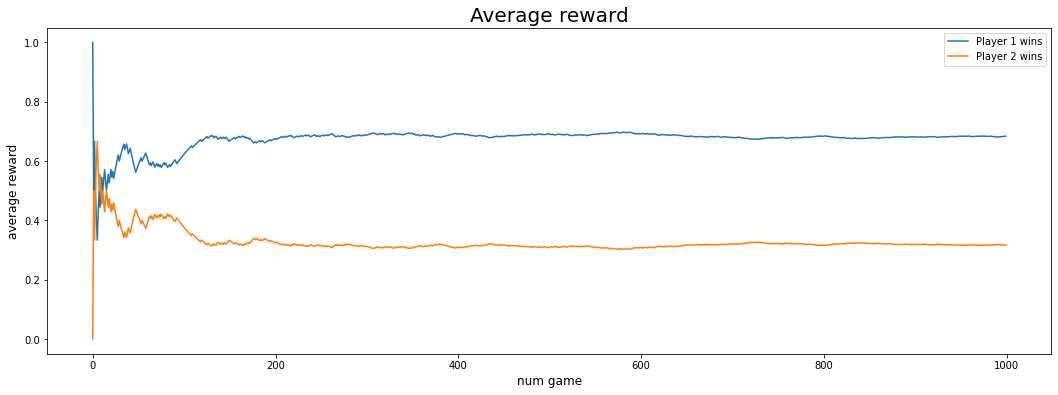

In [172]:
num_games = 1000
grid_size = 3

p1 = TQPlayer(PLAYER1, grid_size=grid_size)
p2 = RandomPlayer(PLAYER2)

p1_counts, p2_counts, games, turn_times_list, game_times = play_n_games(p1, p2, num_games, grid_size=grid_size, suppress_game_tqdm=True, print_wins=True)

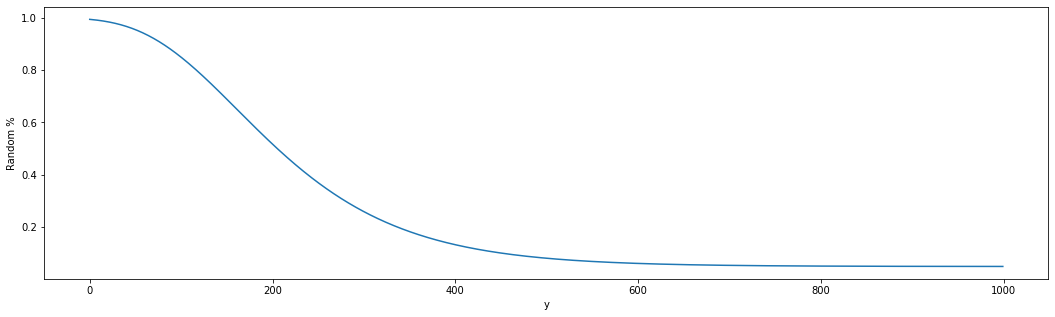

In [177]:
t = np.arange(1000)
x = 1-(0.95 * np.exp(-5 * np.exp(-0.01*t)))

plt.figure(figsize=(18,5))
plt.plot(t, x)
plt.xlabel('y')
plt.ylabel('Random %')
plt.show()

  0%|          | 0/1000 [00:00<?, ?game/s]

After 1000 games, we have:
  - Player 1 wins: 679 (67.90%)
  - Player 2 wins: 321 (32.10%)
Average game time: 0.002s
Average turn time: 0.0002s


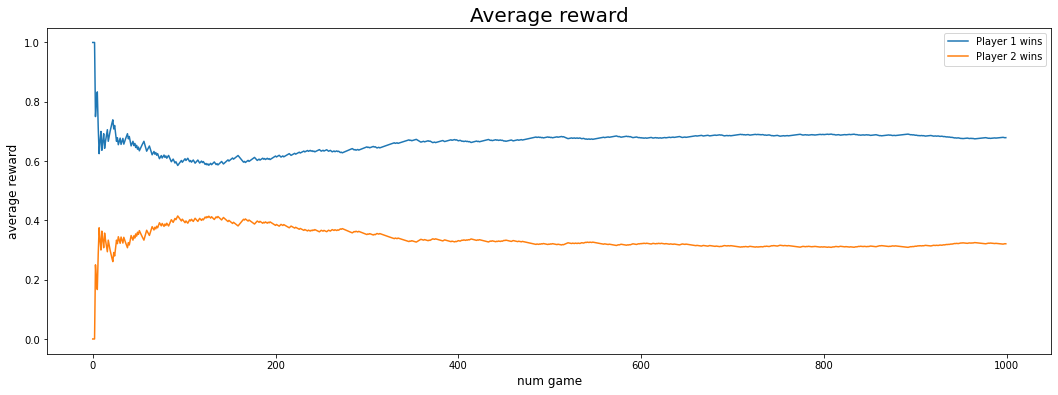

In [190]:
'''
With a better epsilon function
'''
num_games = 1000
grid_size = 3

p1 = TQPlayer(PLAYER1, grid_size=grid_size, epsilon=(lambda t: 1-(0.99 * np.exp(-5 * np.exp(-0.005*t)))))
p2 = RandomPlayer(PLAYER2)

p1_counts, p2_counts, games, turn_times_list, game_times = play_n_games(p1, p2, num_games, grid_size=grid_size, suppress_game_tqdm=True, print_wins=True)

  0%|          | 0/1000 [00:00<?, ?game/s]

After 1000 games, we have:
  - Player 1 wins: 566 (56.60%)
  - Player 2 wins: 434 (43.40%)
Average game time: 0.004s
Average turn time: 0.0002s


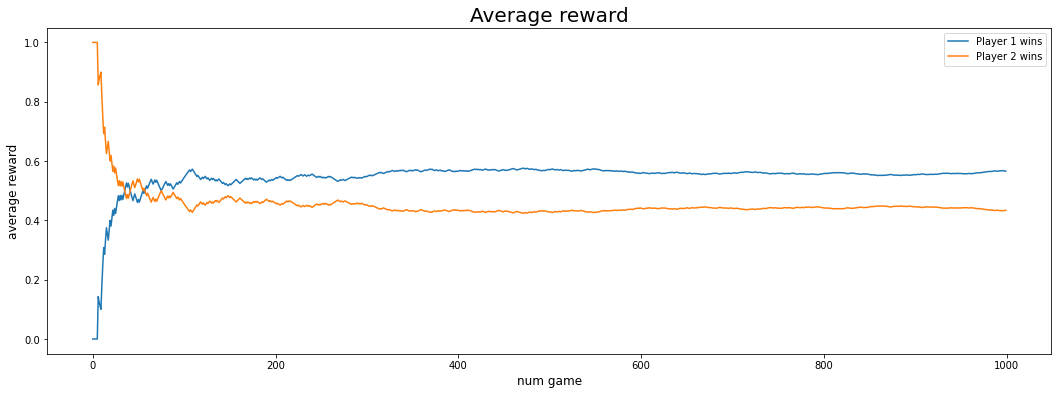

In [170]:
num_games = 1000
grid_size = 5

p1 = TQPlayer(PLAYER1, grid_size=grid_size, epsilon=(lambda t: 1-(0.95 * np.exp(-5 * np.exp(-0.01*t)))))
p2 = RandomPlayer(PLAYER2)

p1_counts, p2_counts, games, turn_times_list, game_times = play_n_games(p1, p2, num_games, grid_size=grid_size, suppress_game_tqdm=True, print_wins=True)

  0%|          | 0/1000 [00:00<?, ?game/s]

After 1000 games, we have:
  - Player 1 wins: 550 (55.00%)
  - Player 2 wins: 450 (45.00%)
Average game time: 0.009s
Average turn time: 0.0002s


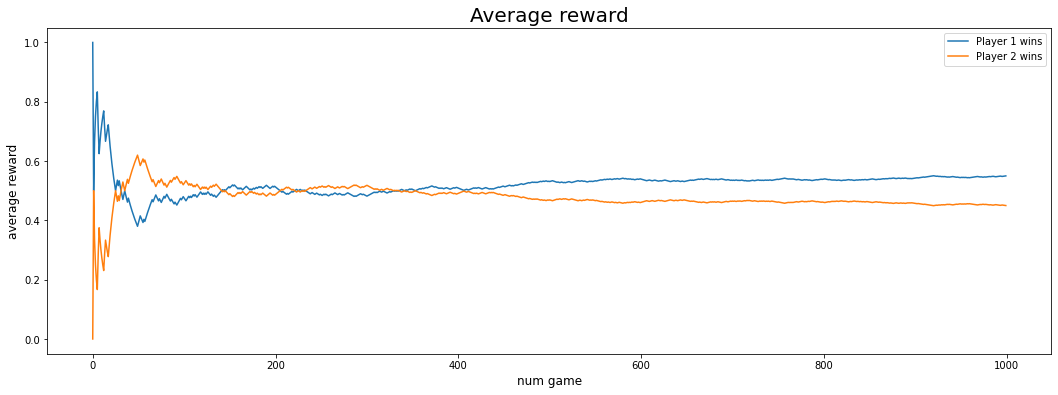

In [126]:
num_games = 1000
grid_size = 7

p1 = TQPlayer(PLAYER1, grid_size=grid_size)
p2 = RandomPlayer(PLAYER2)

p1_counts, p2_counts, games, turn_times_list, game_times = play_n_games(p1, p2, num_games, grid_size=grid_size, suppress_game_tqdm=True, print_wins=True)

#### 4.1.3) Player results

We can see that the agent manages to perform well against a random oponent but only on a 3x3 board. Any attempts at bigger board didn't yield any satisfying results with the default parameters of Q-learning. We could attempt to improve those results by tuning the parameters for larger board but I would expect it to have diminishing returns as the board grows knowing it would need increasingly big q-table to perform well. This would come with an increased requirement for storage (due to the amound of state action pairs to remember) but also of time as exploring a game with this deep of a branching factor is infeasible. Another drawback of this approach is the fact it is unable to recognise local patterns (on a sub-grid for example).

### 4.2) Deep Q-learning Player

#### 4.2.1) Player definition

In [215]:
class DeepQPlayer(TQPlayer):
    def __init__(self, side, grid_size, alpha=0.9, gamma=0.95, q_init=0.6, epsilon=lambda t: 1/t):
        super().__init__(side, grid_size, alpha, gamma, q_init, epsilon)
        
        # Definition of the models
        self.model = self.generate_model() # Trains every 4 game
        self.target_model = self.generate_model() # Copies from model every 100 games
        self.target_model.set_weights(self.model.get_weights())
        
        # Game counter
        self.game_nb = 0
        
        
    def generate_model(self) -> Model:
        # Build a model
        inputs = Input(shape=(self.grid_size, self.grid_size, 6))

        # Layer 0
        l0_3 = Conv2D(32, kernel_size=(3,3), padding='same')(inputs)
        l0_5 = Conv2D(96, kernel_size=(5,5), padding='same')(inputs)
        l0_t = concatenate([l0_3,l0_5])
        l0 = LeakyReLU(alpha=0.1)(l0_t)

        # Layer 1
        l1_3 = Conv2D(64, kernel_size=(3,3), padding='same')(l0)
        l1_5 = Conv2D(64, kernel_size=(5,5), padding='same')(l0)
        l1_t = concatenate([l1_3,l1_5])
        l1 = LeakyReLU(alpha=0.1)(l1_t)

        # Layer 2
        l2_3 = Conv2D(96, kernel_size=(3,3), padding='same')(l1)
        l2_5 = Conv2D(32, kernel_size=(5,5), padding='same')(l1)
        l2_t = concatenate([l2_3,l2_5])
        l2 = LeakyReLU(alpha=0.1)(l2_t)

        # Layer 3
        l3_3 = Conv2D(112, kernel_size=(3,3), padding='same')(l2)
        l3_5 = Conv2D(16, kernel_size=(5,5), padding='same')(l2)
        l3_t = concatenate([l3_3,l3_5])
        l3 = LeakyReLU(alpha=0.1)(l3_t)

        # Layer 4
        l4_3 = Conv2D(120, kernel_size=(3,3), padding='same')(l3)
        l4_5 = Conv2D(8, kernel_size=(5,5), padding='same')(l3)
        l4_t = concatenate([l4_3,l4_5])
        l4 = LeakyReLU(alpha=0.1)(l4_t)

        # Layer 5
        l5_3 = Conv2D(124, kernel_size=(3,3), padding='same')(l4)
        l5_5 = Conv2D(4, kernel_size=(5,5), padding='same')(l4)
        l5_t = concatenate([l5_3,l5_5])
        l5 = LeakyReLU(alpha=0.1)(l5_t)

        # Layer 6
        l6_3 = Conv2D(126, kernel_size=(3,3), padding='same')(l5)
        l6_5 = Conv2D(2, kernel_size=(5,5), padding='same')(l5)
        l6_t = concatenate([l6_3,l6_5])
        l6 = LeakyReLU(alpha=0.1)(l6_t)

        # Layer 7
        l7_3 = Conv2D(128, kernel_size=(3,3), padding='same')(l6)
        l7_5 = Conv2D(0, kernel_size=(5,5), padding='same')(l6)
        l7_t = concatenate([l7_3,l7_5])
        l7 = LeakyReLU(alpha=0.1)(l7_t)

        # Dense layer
        l8_f = Flatten()(l7)
        outputs = Dense(self.grid_size**2, activation=sigmoid)(l8_f)

        # Model
        model = Model(inputs, outputs)
        model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])
        
        return model
    
        
    def finalize(self, result):
        self.game_nb += 1
            
        # Check if model is to be trained
        if self.game_nb % 4 == 0:
            self.train_model()
        
        # Check if model's weights have to be copied to target model
        if self.game_nb % 100 == 0:
            self.target_model.set_weights(self.model.get_weights())
            
        # Reset t
        self.t = 1
        
        
    def train_model(self):
        if len(self.move_history) < 1000:
            return
        
        batch_size = 128
        
        # Shuffle the experience to create nice input data for the training for the model
        batch = random.sample(self.move_history, batch_size)
        
        # Get q arrays based on the states we have explored
        current_states = np.array([exp[0] for exp in batch])
        current_qs_list = self.model.predict(current_states)
        
        # Get q arrays for the new states (result of the action) based on the target model
        new_states = np.array([exp[3] for exp in batch])
        future_qs_list = self.target_model.predict(new_states)
        
        # Training data
        x = []
        y = []
        
        for i, (state, move, reward, new_state, done) in enumerate(batch):
            if not done:
                max_future_q = reward + discount_factor * np.max(future_qs_list[i])
            else:
                max_future_q = reward
                
            current_qs = current_qs_list[i]
            current_qs[move] = (1 - self.learning_rate) * current_qs[move] + self.learning_rate * max_future_q

            X.append(observation)
            Y.append(current_qs)

        self.model.fit(x,y, verbose=0, batch_size=batch_size)

        
    def move(self, grid:HexGrid):
        # Save grid state channels before move
        state_channels = grid.state_channels
        
        if random.random() > self.epsilon(self.t):
            # Do random move
            move_tile = random.choice(grid.empty_tiles)
            move = int((move_tile.y*grid.size)+move_tile.x)
        else:
            # Retrieve the q-values for the current state
            qvals = self.get_q(state_channels)

            # Loop from the highest q_values to find a valid move (an empty tile)
            while True:
                move = np.argmax(qvals)
                move_tile = grid.tiles[move]

                # if the move is legal, return it.
                # Otherwise set the Q-value (for that move) in the Q-table as -1 
                if move_tile.status == EMPTY:
                    break
                qvals[move] = -1.0
            
        # Make and record the move in the move history list for this game
        move_tile.status = self.side
        new_state_channels = grid.state_channels
        
        reward = WIN_VALUE if grid.check_win_player(self.side) else -0.01 # Move discount
        done = grid.check_win_player(self.side)

        self.move_history.append((state_channels, move, reward, new_state_channels, done))
                
        # Update t value to update epsilon
        self.t += 1
    
        
    def get_q(self, state_channels):
        return self.model.predict(np.array([state_channels]))[0]
        

PLAYER_CLASSES['Deep-Q'] = DeepQPlayer

#### 4.2.2) Player testing

  0%|          | 0/1000 [00:00<?, ?game/s]

After 1000 games, we have:
  - Player 1 wins: 674 (67.40%)
  - Player 2 wins: 326 (32.60%)
Average game time: 0.005s
Average turn time: 0.0006s


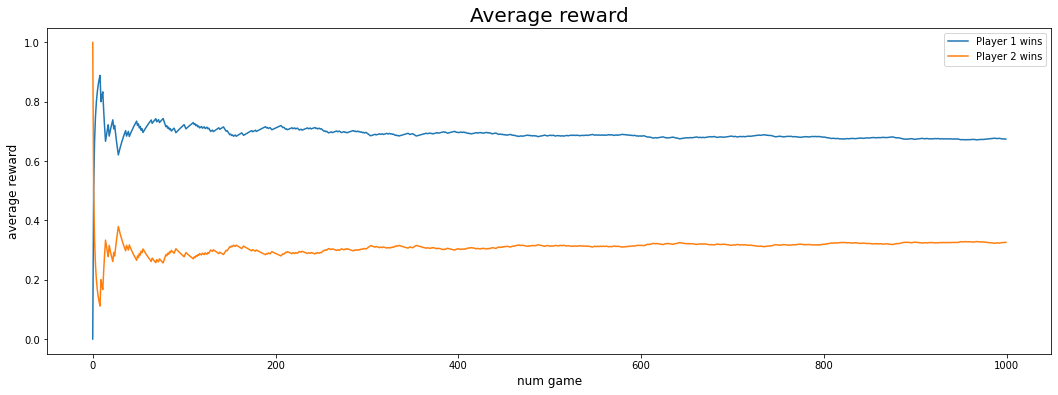

In [209]:
num_games = 1000
grid_size = 3

p1 = DeepQPlayer(PLAYER1, grid_size=grid_size)
p2 = RandomPlayer(PLAYER2)

p1_counts, p2_counts, games, turn_times_list, game_times = play_n_games(p1, p2, num_games, grid_size=grid_size, suppress_game_tqdm=True, print_wins=True)

  0%|          | 0/10000 [00:00<?, ?game/s]

After 10000 games, we have:
  - Player 1 wins: 5259 (52.59%)
  - Player 2 wins: 4741 (47.41%)
Average game time: 0.09s
Average turn time: 0.0008s


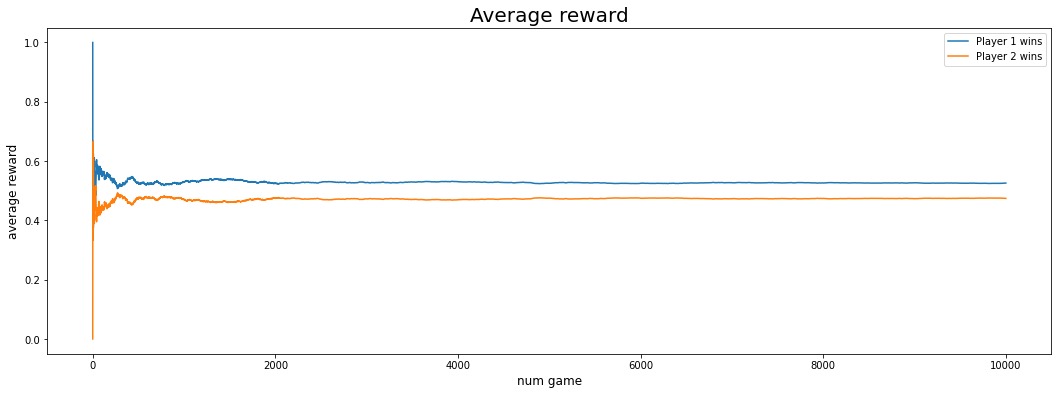

In [224]:
num_games = 10000
grid_size = 11

p1 = DeepQPlayer(PLAYER1, grid_size=grid_size, epsilon=lambda t: 0.01)
p2 = RandomPlayer(PLAYER2)

p1_counts, p2_counts, games, turn_times_list, game_times = play_n_games(p1, p2, num_games, grid_size=grid_size, suppress_game_tqdm=True, print_wins=True)

#### 4.2.3) Player Results

From running this player on a smaller grid, we can see that it works. Now, for it to work on a larger grid, we both need time and adequate training. In my test, we can see that it manages to perform slightly better than on pure average (basing this on the fact a random player playing in 1st position wins between 50 and 52 percent of time) as this player gets closer to a 53% average win.

## 5) Result analysis and conclusions

In this project, I managed to successfully build a minimax player, a TQ-learning player and Deep-Q learning player applied to the game of Hex. 

The most successful approach I managed to get with this game is the Minimax player with a search depth of 1. This performed the best as it rewards immediate best actions. Something that this approach would be lacking is the learning of strategies and counters to opponents actions. This is something that can only be provided by reinforcement learning. The search space being so immense, the only feasible option is to go for deep learning. This would allow for patterns to be learned and surpass the performance of minimax. Although a working implementation of Deep-Q learning was built, it would need a way longer training time to reach this goal.

Overall, I am happy with the implementation so far and it is a subject I would be willing to keep on exploring further in the future.

## 6) A bit of fun (Game UI)

### 6.1) Classes

In [ ]:
class HexaCanvas(Canvas):
    """ A canvas that provides a create-hexagone method """
    def __init__(self, master, hex_size, *args, **kwargs):
        Canvas.__init__(self, master, *args, **kwargs)
        self.hex_size = hex_size


    def create_hexagone(self, x, y, color = "black", fill="grey", color1=None, color2=None, color3=None, color4=None, color5=None, color6=None):
        """ 
        Compute coordinates of 6 points relative to a center position.
        Point are numbered following this schema :

        Points in euclidiean grid:  
                    6

                5       1
                    .
                4       2

                    3

        Each color is applied to the side that link the vertex with same number to its following.
        Ex : color 1 is applied on side (vertex1, vertex2)

        Take care that tkinter ordinate axes is inverted to the standard euclidian ones.
        Point on the screen will be horizontally mirrored.
        Displayed points:

                    3
              color3/      \color2      
                4       2
            color4|     |color1
                5       1
              color6\      /color6
                    6

        """
        size = self.hex_size
        dx = (size**2 - (size/2)**2)**0.5

        point1 = (x+dx, y+size/2)
        point2 = (x+dx, y-size/2)
        point3 = (x   , y-size  )
        point4 = (x-dx, y-size/2)
        point5 = (x-dx, y+size/2)
        point6 = (x   , y+size  )

        #this setting allow to specify a different color for each side.
        if color1 == None:
            color1 = color
        if color2 == None:
            color2 = color
        if color3 == None:
            color3 = color
        if color4 == None:
            color4 = color
        if color5 == None:
            color5 = color
        if color6 == None:
            color6 = color
        
        # Make bold if a different color than default is asked (ie for the borders)
        self.create_line(point1, point2, fill=color1, width=2 + (3 if color1 != color else 0))
        self.create_line(point2, point3, fill=color2, width=2 + (3 if color2 != color else 0))
        self.create_line(point3, point4, fill=color3, width=2 + (3 if color3 != color else 0))
        self.create_line(point4, point5, fill=color4, width=2 + (3 if color4 != color else 0))
        self.create_line(point5, point6, fill=color5, width=2 + (3 if color5 != color else 0))
        self.create_line(point6, point1, fill=color6, width=2 + (3 if color6 != color else 0))

        if fill != None:
            return self.create_polygon(point1, point2, point3, point4, point5, point6, fill=fill)

In [ ]:
class HexGridCanvas(HexaCanvas):
    def __init__(self, master, hex_grid:HexGrid, scale, pad=10):
        # Variable setting
        self.master = master
        self.hex_grid = hex_grid
        
        # Field dimentions and definition
        dx     = (scale**2 - (scale/2.0)**2)**0.5
        width  = 2*dx*self.hex_grid.size + (self.hex_grid.size-1)*dx + 2*pad
        height = 1.5*scale*self.hex_grid.size + 0.5*scale + 2*pad
        HexaCanvas.__init__(self, master, hex_size=scale, background='white', width=width, height=height)

        # Definition of the hexes
        self.tile_ids = []
        self.tile_dict = {}
        for tile in self.hex_grid.tiles:
            color_args = {}
            if tile.x == 0:
                color_args['color4'] = TILE_COLORS[PLAYER2]
                color_args['color5'] = TILE_COLORS[PLAYER2]
            if tile.x == self.hex_grid.size-1:
                color_args['color1'] = TILE_COLORS[PLAYER2]
                color_args['color2'] = TILE_COLORS[PLAYER2]
            if tile.y == 0:
                color_args['color2'] = TILE_COLORS[PLAYER1]
                color_args['color3'] = TILE_COLORS[PLAYER1]
            if tile.y == self.hex_grid.size-1:
                color_args['color5'] = TILE_COLORS[PLAYER1]
                color_args['color6'] = TILE_COLORS[PLAYER1]

            pix_x = dx + 2*dx*tile.x + tile.y*dx + pad
            pix_y = scale + tile.y*1.5*scale + pad

            tile_id = self.create_hexagone(pix_x, pix_y, fill=TILE_COLORS[EMPTY], **color_args)
            self.tile_ids.append(tile_id)
            self.tile_dict[tile_id] = tile
                
                
    def get_tile_id(self, x, y):
        return self.tile_ids[int((y*self.hex_grid.size)+x)]
    
    def get_tile(self, tile_id):
        return self.tile_dict[tile_id]
    
    
    def set_tile_color(self, x, y, color):
        self.itemconfig(self.get_tile_id(x,y), fill=color)
        
    def set_tile_id_color(self, tile_id, color):
        self.itemconfig(tile_id, fill=color)

In [ ]:
class HexGameUI(Tk):
    def __init__(self, tick_speed=100, game:HexGame=None):
        super().__init__()
        
        # Variables
        self.tick_speed = tick_speed
        self.game = game
        
        # Frames and panes
        self.frame = None
        self.bottom_pane = None
        self.side_pane = None
        
        self.wm_title('Project - HexGame')
        self.iconbitmap('hex.ico')
        
        self.setup_menu_frame()
        self.mainloop()
        
        
    def setup_menu_frame(self):
        # If frame exists destroy it first
        if self.frame:
            self.frame.destroy()
        
        # State variables
        self.frame = Frame(self)
        
        # Bottom pane config
        if self.bottom_pane:
            self.bottom_pane.destroy()
        self.bottom_pane = Frame(self.frame)
        self.bottom_pane.grid(row=0, column=0)
        
        Button(self.bottom_pane, text='Start Game', command=self.retrieve_game_configs).grid(row=0, column=0)
        
        # Side pane config
        if self.side_pane:
            self.side_pane.destroy()
        self.side_pane = Frame(self.frame)
        self.side_pane.grid(row=0, column=1, rowspan=2)
        
        Label(self.side_pane, text='Game config').grid(row=0, column=0, columnspan=2)
        
        Label(self.side_pane, text='Size').grid(row=1, column=0)
        self.game_size_choice = Entry(self.side_pane)
        self.game_size_choice.insert(10, 11)
        self.game_size_choice.grid(row=1, column=1)
        
        Label(self.side_pane, text='Player 1', fg=TILE_COLORS[PLAYER1]).grid(row=2, column=0)
        self.player1_choice = StringVar(self.side_pane)
        self.player1_choice.set(list(PLAYER_CLASSES.keys())[0])
        OptionMenu(self.side_pane, self.player1_choice, *list(PLAYER_CLASSES.keys())).grid(row=2, column=1)
        
        Label(self.side_pane, text='Player 2', fg=TILE_COLORS[PLAYER2]).grid(row=3, column=0)
        self.player2_choice = StringVar(self.side_pane)
        self.player2_choice.set(list(PLAYER_CLASSES.keys())[0])
        OptionMenu(self.side_pane, self.player2_choice, *list(PLAYER_CLASSES.keys())).grid(row=3, column=1)
        
        self.frame.pack()
        

    def retrieve_game_configs(self):
        self.player1 = PLAYER_CLASSES[self.player1_choice.get()](PLAYER1)
        self.player2 = PLAYER_CLASSES[self.player2_choice.get()](PLAYER2)
        self.game_size = int(self.game_size_choice.get())
        
        self.generate_game()
        
        
    def generate_game(self):
        self.game = HexGame(player1=self.player1,
                            player2=self.player2,
                            grid_size=self.game_size)
        self.start_game()
        
        
    def start_game(self):
        assert self.game
        
        # Game canvas setup
        self.game_canvas = HexGridCanvas(self.frame, self.game.grid, scale=25)
        self.game_canvas.grid(row=0, column=0)
        
        self.game.status = STARTED
        
        # Link hexes to move action
        for tile_id in self.game_canvas.tile_ids:
            self.game_canvas.tag_bind(tile_id, '<Enter>', self.toggle_highlight)
            self.game_canvas.tag_bind(tile_id, '<Leave>', self.toggle_highlight)
            self.game_canvas.tag_bind(tile_id, '<ButtonPress-1>', self.tile_click)
        
        # Bottom pane controls config
        if self.bottom_pane:
            self.bottom_pane.destroy()
        self.bottom_pane = Frame(self.frame)
        self.bottom_pane.grid(row=1, column=0)
        
        Button(self.bottom_pane, text='Pause Game', command=self.pause_toggle).grid(row=0, column=0)
        Button(self.bottom_pane, text='Reset Game', command=self.reset_confirmation).grid(row=0, column=1)
        Button(self.bottom_pane, text='Back to menu', command=self.menu_confirmation).grid(row=0, column=2)

        # Side pane config
        if self.side_pane:
            self.side_pane.destroy()
        self.side_pane = Frame(self.frame)
        self.side_pane.grid(row=0, column=1, rowspan=2)
        
        Label(self.side_pane, text='Active player:').grid(row=1, column=0)
        active_player_nb = self.game.active_player_nb
        self.active_player_lbl = Label(self.side_pane, text=f'Player {active_player_nb}', fg=TILE_COLORS[active_player_nb])
        self.active_player_lbl.grid(row=1, column=1)
        
        Label(self.side_pane, text='Game speed').grid(row=2, column=0)
        self.game_speed_choice = StringVar(self.side_pane)
        self.game_speed_choice.set(list(GAME_SPEEDS.keys())[1]) # Default is Normal speed
        OptionMenu(self.side_pane, self.game_speed_choice, *list(GAME_SPEEDS.keys())).grid(row=2, column=1)
        
        # Start game loop
        self.game_step()
        
        
    def finish_game(self, winner):
        self.game.status = FINISHED
        popup = Tk()
        popup.wm_title('Game done!')
        label = Label(popup, text=f'Player {winner} won!', fg=TILE_COLORS[winner])
        label.pack(side="top", fill="x", pady=10)
        B1 = Button(popup, text="Okay", command = popup.destroy)
        B1.pack()
        popup.mainloop()
                
        
    def pause_toggle(self):
        if self.game.status == STARTED:
            self.game.status = STOPPED
        if self.game.status == STOPPED:
            self.game.status = STARTED
        
        
    def reset_confirmation(self):
        answer = askyesno(title='Reset confirmation', message='Are you sure that you want to reset?')
        if answer:
            self.generate_game()
            
            
    def menu_confirmation(self):
        answer = askyesno(title='Back to menu confirmation', message='Are you sure that you want to go back to menu?')
        if answer:
            self.setup_menu_frame()
    
    
    def game_step(self):
        if self.game.status == STARTED:
            if isinstance(self.game.active_player, ManualPlayer):
                pass
            else:
                self.game.active_player.move(self.game.grid)
        
                # Check for victory and finalize game
                if self.game.grid.check_win_player(self.game.active_player_nb):
                    self.finish_game(self.game.active_player_nb)
                    
                self.switch_player()

        # Update tickspeed
        self.tick_speed = GAME_SPEEDS[self.game_speed_choice.get()]
            
        # Set trigger for next iteration
        self.after(self.tick_speed, self.game_step)
    

    def tile_click(self, event):
        if self.game.status == STARTED and isinstance(self.game.active_player, ManualPlayer):
            tile_id = event.widget.find_withtag('current')[0]
            tile = self.game_canvas.get_tile(tile_id)
            
            if tile.status not in [PLAYER1, PLAYER2]:
                # Set tile status
                self.game_canvas.get_tile(tile_id).status = self.game.active_player_nb
                
                # Increase turn_number
                self.game.grid.turn_number += 1

                # Adapt UI color
                self.game_canvas.set_tile_id_color(tile_id, TILE_COLORS[self.game.active_player.side])
                
                # Check for victory and finalize game
                if self.game.grid.check_win_player(self.game.active_player_nb):
                    self.finish_game(self.game.active_player_nb)

                self.switch_player()
        

    def toggle_highlight(self, event):
        if self.game.status == STARTED and isinstance(self.game.active_player, ManualPlayer):
            # Get tile
            tile_id = event.widget.find_withtag('current')[0]
            tile = self.game_canvas.get_tile(tile_id)
            
            # Change tile status and UI color
            if tile.status == EMPTY:
                tile.status = HOVERED
                self.game_canvas.set_tile_id_color(tile_id, TILE_COLORS[HOVERED])
            elif tile.status == HOVERED:
                tile.status = EMPTY
                self.game_canvas.set_tile_id_color(tile_id, TILE_COLORS[EMPTY])


    def switch_player(self):
        self.game.switch_player()
        
        # Adapt label
        active_player_nb = self.game.active_player_nb
        self.active_player_lbl.config(text=f'Player {active_player_nb}', fg=TILE_COLORS[active_player_nb])

### 6.2) Start UI

In [2]:
'''
Command to start the UI
'''
# HexGameUI()

'\nCommand to start the UI\n'

## 7) Sources

- Hexagon knowledge: https://www.redblobgames.com/grids/hexagons
- Path finding (win checking and shortest path): https://www.redblobgames.com/pathfinding/a-star/introduction.html

---

- Minimax AI (with Dijstra heuristic): https://gsurma.medium.com/hex-creating-intelligent-opponents-with-minimax-driven-ai-part-1-%CE%B1-%CE%B2-pruning-cc1df850e5bd
- Alpha-beta pruning: https://www.geeksforgeeks.org/minimax-algorithm-in-game-theory-set-4-alpha-beta-pruning/
- LPA*: <a href="https://en.wikipedia.org/wiki/Lifelong_Planning_A*">https://en.wikipedia.org/wiki/Lifelong_Planning_A*</a>
- Minimax for hex vs monte carlo: http://web.stanford.edu/class/archive/cs/cs221/cs221.1192/2018/restricted/posters/eliew/poster.pdf
- Improving minimax: https://levelup.gitconnected.com/improving-minimax-performance-fc82bc337dfd

---

- Reinforcement learning applied to games: https://link.springer.com/article/10.1007/s42452-020-2560-3
- Deep reinforcement learning: https://www.mlq.ai/deep-reinforcement-learning-q-learning/
- Deep-Q learning principles: https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc#:~:text=Critically%2C%20Deep%20Q%2DLearning%20replaces,process%20uses%202%20neural%20networks.
- Deep-Q learning settlers of catan: https://akrishna77.github.io/QSettlers/
- Deep-Q learning tutorial: https://pythonprogramming.net/training-deep-q-learning-dqn-reinforcement-learning-python-tutorial/?completed=/deep-q-learning-dqn-reinforcement-learning-python-tutorial/
- Deep-Q learning tic-tac-toe: https://towardsdatascience.com/reinforcement-learning-and-deep-reinforcement-learning-with-tic-tac-toe-588d09c41dda
- Hexagon kernel CCN layer: https://www.youtube.com/watch?v=pImJayaXmCM
- Neurohex: https://www.researchgate.net/publication/301648362_Neurohex_A_Deep_Q-learning_Hex_Agent